In [10]:
from google.colab import files
uploaded = files.upload()

Saving netflix_titles.csv.zip to netflix_titles.csv.zip


In [11]:
from google.colab import files
uploaded = files.upload()

Saving title.ratings.tsv.gz to title.ratings.tsv.gz


In [13]:
from google.colab import files
uploaded = files.upload()

Saving title.basics.tsv.gz to title.basics.tsv.gz


In [14]:
import pandas as pd

# Load IMDb basics
basics = pd.read_csv("title.basics.tsv.gz", sep="\t", low_memory=False, na_values="\\N")

# Load IMDb ratings
ratings = pd.read_csv("title.ratings.tsv.gz", sep="\t")

print(basics.head())
print(ratings.head())

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear  endYear runtimeMinutes                    genres  
0        0     1894.0      NaN              1         Documentary,Short  
1        0     1892.0      NaN              5           Animation,Short  
2        0     1892.0      NaN              5  Animation,Comedy,Romance  
3        0     1892.0      NaN             12           Animation,Short  
4        0     1893.0      NaN              1                     Short  
      tconst  averageRating  numVotes
0  tt0000001            5.7      2180
1  tt0000002            5.5       3

In [15]:
import pandas as pd

# Re-read (safe to run again)
basics  = pd.read_csv("title.basics.tsv.gz",  sep="\t", low_memory=False, na_values="\\N")
ratings = pd.read_csv("title.ratings.tsv.gz", sep="\t", low_memory=False)

# 1) Normalize column names (strip weird spaces, etc.)
basics.columns  = basics.columns.str.strip()
ratings.columns = ratings.columns.str.strip()

# 2) If tconst got set as an index anywhere, put it back as a column
if basics.index.name == "tconst" and "tconst" not in basics.columns:
    basics = basics.reset_index()
if ratings.index.name == "tconst" and "tconst" not in ratings.columns:
    ratings = ratings.reset_index()

# 3) Quick sanity prints
print("basics cols:", list(basics.columns)[:10])
print("ratings cols:", list(ratings.columns)[:10])
print("tconst in basics?", "tconst" in basics.columns)
print("tconst in ratings?", "tconst" in ratings.columns)

# 4) If somehow the column header has hidden characters, fix them explicitly
#    (rare, but handy)
for df in (basics, ratings):
    if "tconst" not in df.columns:
        # try to locate a header that LOOKS like tconst
        for c in df.columns:
            if c.strip().lower() == "tconst":
                df.rename(columns={c: "tconst"}, inplace=True)

# 5) Final check and merge
assert "tconst" in basics.columns,  "No 'tconst' in basics after cleaning."
assert "tconst" in ratings.columns, "No 'tconst' in ratings after cleaning."

imdb = basics.merge(ratings, on="tconst", how="inner", validate="one_to_one")
print(imdb.shape)
imdb.head()

basics cols: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']
ratings cols: ['tconst', 'averageRating', 'numVotes']
tconst in basics? True
tconst in ratings? True
(1616746, 11)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1,"Documentary,Short",5.7,2180
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5,"Animation,Short",5.5,301
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892.0,NaN,5,"Animation,Comedy,Romance",6.4,2248
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12,"Animation,Short",5.2,194
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1,Short,6.2,2989


In [16]:
# Keep only movies / TV series and necessary fields
imdb_use = (
    imdb[imdb["titleType"].isin(["movie","tvSeries"])]
    .loc[:, ["tconst","titleType","primaryTitle","startYear","genres","averageRating","numVotes"]]
    .rename(columns={"primaryTitle":"title", "startYear":"year"})
)

# Clean types
imdb_use["year"] = pd.to_numeric(imdb_use["year"], errors="coerce")

In [17]:
netflix = pd.read_csv("netflix_titles.csv.zip")

# Normalize titles for matching
netflix["title_norm"] = netflix["title"].str.strip().str.lower()
imdb_use["title_norm"] = imdb_use["title"].str.strip().str.lower()

# Prefer matching by title + year when available
merged_nfx = pd.merge(
    netflix,
    imdb_use,
    how="inner",
    left_on=["title_norm","release_year"],
    right_on=["title_norm","year"],
    suffixes=("_nfx","_imdb")
)

print("Merged rows:", len(merged_nfx))
merged_nfx.head()

Merged rows: 5387


,show_id,type,title_nfx,director,cast,country,date_added,release_year,rating,duration,listed_in,description,title_norm,tconst,titleType,title_imdb,year,genres,averageRating,numVotes
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",dick johnson is dead,tt11394180,movie,Dick Johnson Is Dead,2020.0,"Biography,Documentary,Drama",7.4,7535
1,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,ganglands,tt13278100,tvSeries,Ganglands,2021.0,"Action,Crime,Drama",7.2,4896
2,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",jailbirds new orleans,tt15320436,tvSeries,Jailbirds New Orleans,2021.0,"Documentary,Reality-TV",6.5,337
3,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,my little pony: a new generation,tt10101702,movie,My Little Pony: A New Generation,2021.0,"Adventure,Animation,Comedy",6.8,4952
4,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",sankofa,tt0108041,movie,Sankofa,1993.0,Drama,7.0,881


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make a working copy
df = merged_nfx.copy()

# Standardize column names we’ll use a lot
df.columns = df.columns.str.strip()

# Keep only rows with an IMDb rating
df = df.dropna(subset=["averageRating"])

# Basic cleaning
df["numVotes"] = pd.to_numeric(df["numVotes"], errors="coerce")
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")

# Split Netflix genres and countries to support per-genre / per-country analysis
df["listed_in"] = df["listed_in"].fillna("").str.split(",")
df["country"]   = df["country"].fillna("").str.split(",")

# Long forms
g_long = df.explode("listed_in").rename(columns={"listed_in":"genre"}).copy()
g_long["genre"] = g_long["genre"].str.strip()
c_long = df.explode("country").rename(columns={"country":"country_name"}).copy()
c_long["country_name"] = c_long["country_name"].str.strip()

# --- IMDb weighted rating (Bayesian) to avoid small-sample bias ---
# C = mean rating over the whole dataset
C = df["averageRating"].mean()
# m = vote-count threshold; choose high-percentile so only popular titles get full weight
m = df["numVotes"].quantile(0.90)  # 90th percentile (adjust if you want stricter/looser)
# Weighted Rating formula:
# WR = (v/(v+m)) * R + (m/(v+m)) * C
df["weighted_rating"] = (
    (df["numVotes"] / (df["numVotes"] + m)) * df["averageRating"] +
    (m / (df["numVotes"] + m)) * C
)

# Proxy for "rewatch rate": more engagement → more votes (use log to stabilize)
df["engagement"] = np.log1p(df["numVotes"])  # log(1 + votes)

print(f"C (mean rating) = {C:.2f},  m (vote threshold) = {m:,.0f}, rows = {len(df):,}")

C (mean rating) = 6.32,  m (vote threshold) = 97,746, rows = 5,387


In [19]:
# Rebuild exploded tables *after* df has weighted_rating & numVotes
needed_cols = ["show_id","type","title_imdb","release_year",
               "listed_in","averageRating","numVotes","weighted_rating"]

# Genre-long
g_long = (df[needed_cols].copy())
g_long["listed_in"] = g_long["listed_in"].fillna("")
g_long = g_long.explode("listed_in").rename(columns={"listed_in":"genre"})
g_long["genre"] = g_long["genre"].str.strip()

# Country-long (if you use it later)
needed_cols_c = ["show_id","country","weighted_rating"]
c_long = df[needed_cols_c].copy()
c_long["country"] = c_long["country"].fillna("")
c_long = c_long.explode("country").rename(columns={"country":"country_name"})
c_long["country_name"] = c_long["country_name"].str.strip()

# Sanity check
print("g_long cols:", g_long.columns.tolist())
print("Has weighted_rating in g_long? ", "weighted_rating" in g_long.columns)
print("Sample:\n", g_long.head(3))

g_long cols: ['show_id', 'type', 'title_imdb', 'release_year', 'genre', 'averageRating', 'numVotes', 'weighted_rating']
Has weighted_rating in g_long?  True
Sample:
   show_id     type            title_imdb  release_year  \
0      s1    Movie  Dick Johnson Is Dead          2020   
1      s3  TV Show             Ganglands          2021   
1      s3  TV Show             Ganglands          2021   

                    genre  averageRating  numVotes  weighted_rating  
0           Documentaries            7.4      7535         6.394394  
1          Crime TV Shows            7.2      4896         6.358999  
1  International TV Shows            7.2      4896         6.358999  


         weighted_rating  averageRating  engagement  numVotes
type                                                         
Movie               6.38           6.18        8.36  47724.29
TV Show             6.37           6.83        6.76   8060.04
                        weighted_rating  averageRating   numVotes
genre                                                            
Classic & Cult TV                  8.00           8.70  236977.00
Classic Movies                     7.01           7.55  238161.92
Cult Movies                        6.75           6.95  249378.63
Anime Series                       6.66           7.60   47660.60
TV Thrillers                       6.58           7.16   80882.27
Dramas                             6.53           6.68   88308.76
Science & Nature TV                6.53           7.81   12436.57
Korean TV Shows                    6.50           7.97   11396.24
TV Sci-Fi & Fantasy                6.50           6.71   40007.57
TV Action & Adventure     

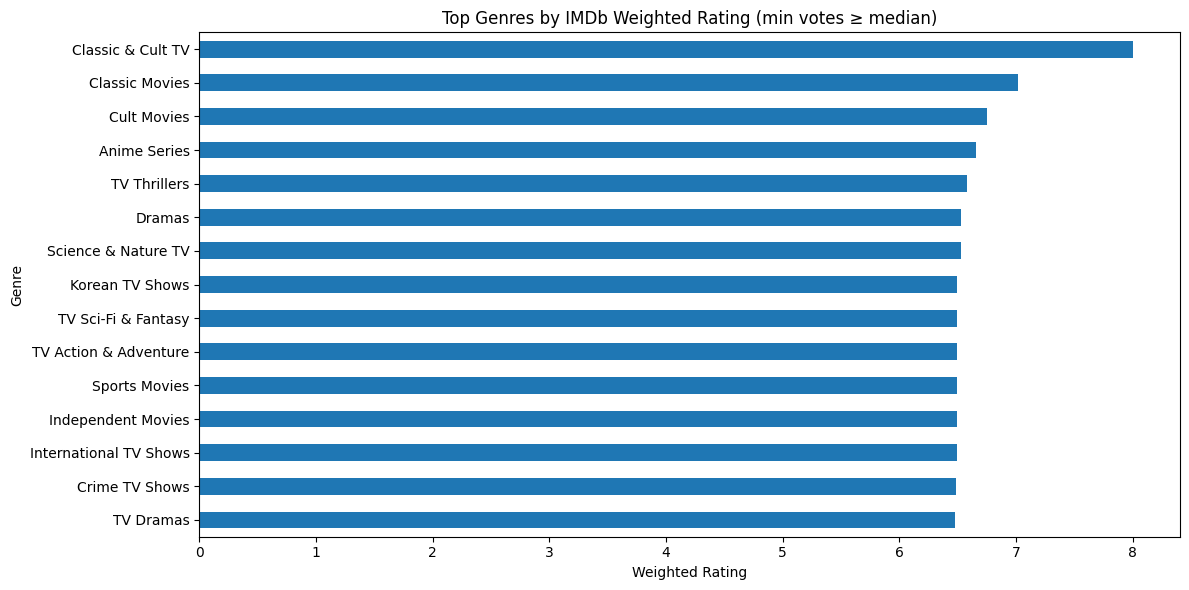

In [20]:
# (A) Type-level view (Movie vs TV Show) – average weighted rating & engagement
type_summary = (
    df.groupby("type")[["weighted_rating","averageRating","engagement","numVotes"]]
      .mean()
      .sort_values("weighted_rating", ascending=False)
)
print(type_summary.round(2))

# (B) Top genres by weighted rating (with a minimum votes filter for reliability)
min_votes = df["numVotes"].quantile(0.50)  # keep titles above the median votes
g_rank = (
    g_long[g_long["genre"].ne("") & (g_long["numVotes"] >= min_votes)]
      .groupby("genre")[["weighted_rating","averageRating","numVotes"]]
      .mean()
      .sort_values("weighted_rating", ascending=False)
      .head(15)
)
print(g_rank.round(2))

# Plot top 15 genres by weighted rating
plt.figure(figsize=(12,6))
g_rank["weighted_rating"].sort_values().plot(kind="barh")
plt.title("Top Genres by IMDb Weighted Rating (min votes ≥ median)")
plt.xlabel("Weighted Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

In [21]:
print(df.columns.tolist())
df.head(3)

['show_id', 'type', 'title_nfx', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'title_norm', 'tconst', 'titleType', 'title_imdb', 'year', 'genres', 'averageRating', 'numVotes', 'weighted_rating', 'engagement']


,show_id,type,title_nfx,director,cast,country,date_added,release_year,rating,duration,...,title_norm,tconst,titleType,title_imdb,year,genres,averageRating,numVotes,weighted_rating,engagement
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,[United States],"September 25, 2021",2020,PG-13,90 min,...,dick johnson is dead,tt11394180,movie,Dick Johnson Is Dead,2020.0,"Biography,Documentary,Drama",7.4,7535,6.394394,8.927447
1,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",[],"September 24, 2021",2021,TV-MA,1 Season,...,ganglands,tt13278100,tvSeries,Ganglands,2021.0,"Action,Crime,Drama",7.2,4896,6.358999,8.496378
2,s4,TV Show,Jailbirds New Orleans,NaN,NaN,[],"September 24, 2021",2021,TV-MA,1 Season,...,jailbirds new orleans,tt15320436,tvSeries,Jailbirds New Orleans,2021.0,"Documentary,Reality-TV",6.5,337,6.317503,5.823046


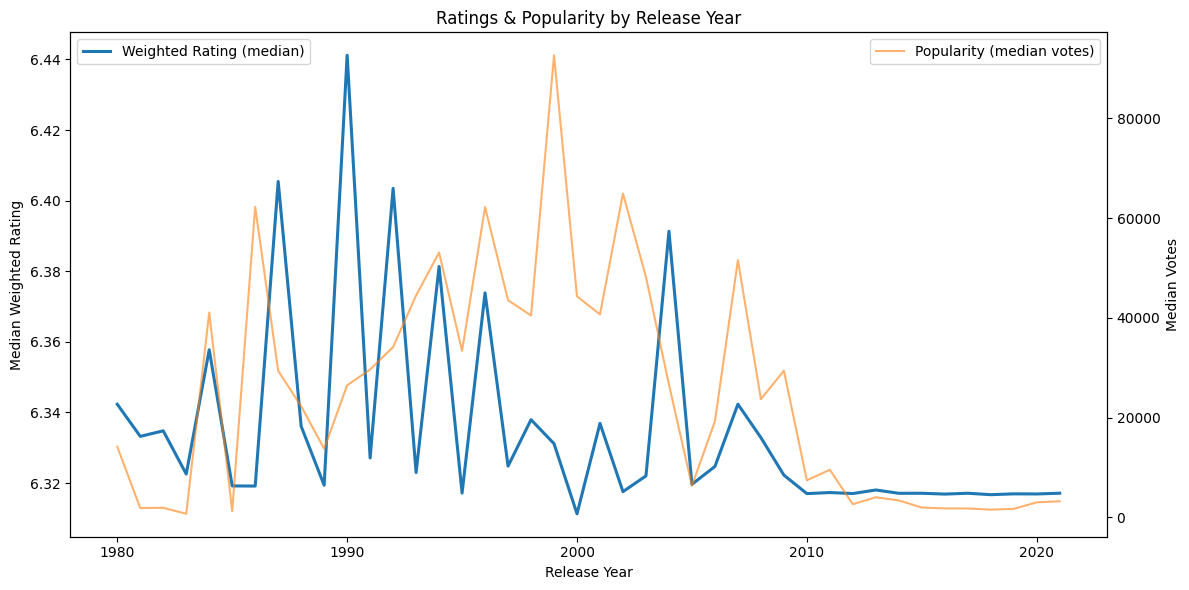

In [22]:
# Yearly trends in rating and engagement
yr = (
    df.dropna(subset=["release_year"])
      .groupby("release_year")[["averageRating","weighted_rating","numVotes"]]
      .median()  # median is robust; switch to mean if you prefer
      .reset_index()
      .query("release_year >= 1980")  # trim noisy early history; adjust as needed
)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(yr["release_year"], yr["weighted_rating"], label="Weighted Rating (median)", linewidth=2.2)
ax1.set_xlabel("Release Year")
ax1.set_ylabel("Median Weighted Rating")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(yr["release_year"], yr["numVotes"], color="tab:orange", alpha=0.6, label="Popularity (median votes)")
ax2.set_ylabel("Median Votes")
ax2.legend(loc="upper right")

plt.title("Ratings & Popularity by Release Year")
plt.tight_layout()
plt.show()

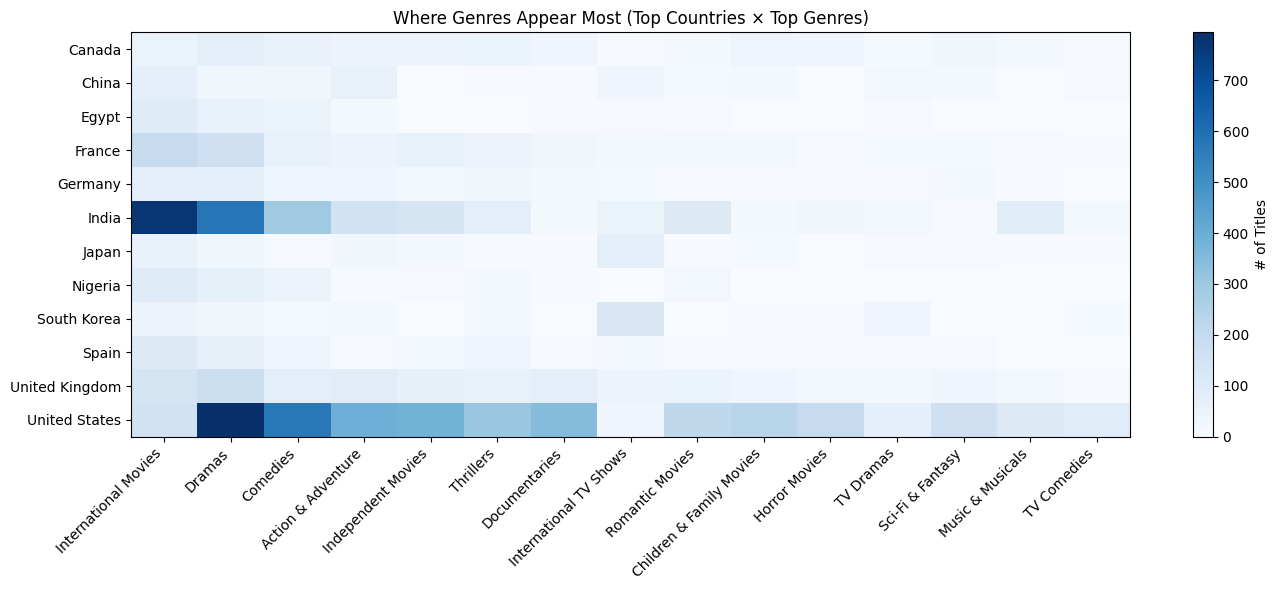

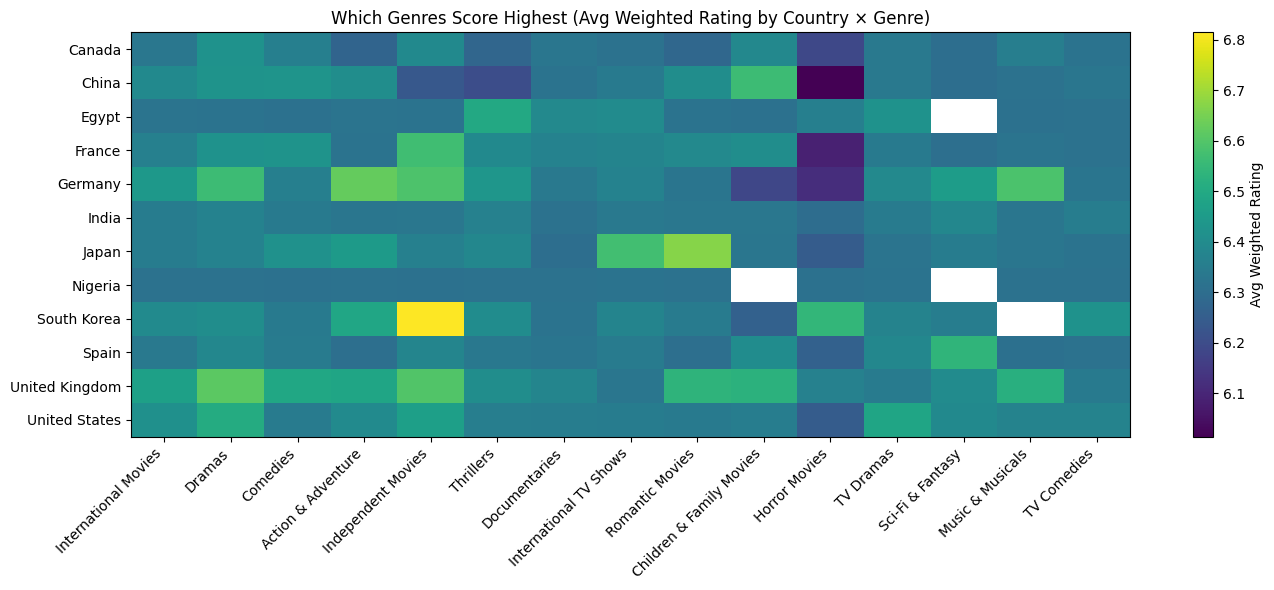

In [23]:
# --- Q3 rating heatmap: make this cell self-sufficient ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Ensure weighted_rating exists
if "weighted_rating" not in df.columns:
    # make sure types are numeric
    df["averageRating"] = pd.to_numeric(df["averageRating"], errors="coerce")
    df["numVotes"]      = pd.to_numeric(df["numVotes"], errors="coerce")
    C = df["averageRating"].mean()
    m = df["numVotes"].quantile(0.90)
    df["weighted_rating"] = (
        (df["numVotes"] / (df["numVotes"] + m)) * df["averageRating"] +
        (m / (df["numVotes"] + m)) * C
    )

# (re)build cg safely (Country × Genre rows) in case earlier cell wasn’t run
g_tmp = df[["show_id","listed_in"]].copy()
g_tmp["listed_in"] = g_tmp["listed_in"].fillna("").astype(object)
g_tmp = g_tmp.explode("listed_in").rename(columns={"listed_in":"genre"})
g_tmp["genre"] = g_tmp["genre"].str.strip()
g_tmp = g_tmp[g_tmp["genre"] != ""]

c_tmp = df[["show_id","country"]].copy()
c_tmp["country"] = c_tmp["country"].fillna("").astype(object)
c_tmp = c_tmp.explode("country").rename(columns={"country":"country_name"})
c_tmp["country_name"] = c_tmp["country_name"].str.strip()
c_tmp = c_tmp[c_tmp["country_name"] != ""]

cg = c_tmp.merge(g_tmp, on="show_id", how="inner")

# pick top countries to keep the heatmap readable
top_countries = (
    cg.groupby("country_name")["show_id"]
      .count()
      .sort_values(ascending=False)
      .head(12)
      .index
)

# 1) COUNT heatmap (already worked for you, keep if you like)
count_pivot = (cg[cg["country_name"].isin(top_countries)]
               .pivot_table(index="country_name", columns="genre", values="show_id",
                            aggfunc="count", fill_value=0))
top_genres = cg["genre"].value_counts().head(15).index
count_pivot = count_pivot.reindex(columns=[g for g in top_genres if g in count_pivot.columns])

plt.figure(figsize=(14,6))
plt.imshow(count_pivot, aspect="auto", cmap="Blues")
plt.colorbar(label="# of Titles")
plt.yticks(range(len(count_pivot.index)), count_pivot.index)
plt.xticks(range(len(count_pivot.columns)), count_pivot.columns, rotation=45, ha="right")
plt.title("Where Genres Appear Most (Top Countries × Top Genres)")
plt.tight_layout()
plt.show()

# 2) RATING heatmap (fixed merge)
rt = cg.merge(
        df.loc[:, ["show_id","weighted_rating"]].dropna(subset=["weighted_rating"]),
        on="show_id", how="left"
     ).dropna(subset=["weighted_rating"])

rt_pivot = (rt[rt["country_name"].isin(top_countries)]
            .pivot_table(index="country_name", columns="genre",
                         values="weighted_rating", aggfunc="mean"))

rt_pivot = rt_pivot.reindex(columns=[g for g in top_genres if g in rt_pivot.columns])

plt.figure(figsize=(14,6))
plt.imshow(rt_pivot, aspect="auto", cmap="viridis")
plt.colorbar(label="Avg Weighted Rating")
plt.yticks(range(len(rt_pivot.index)), rt_pivot.index)
plt.xticks(range(len(rt_pivot.columns)), rt_pivot.columns, rotation=45, ha="right")
plt.title("Which Genres Score Highest (Avg Weighted Rating by Country × Genre)")
plt.tight_layout()
plt.show()

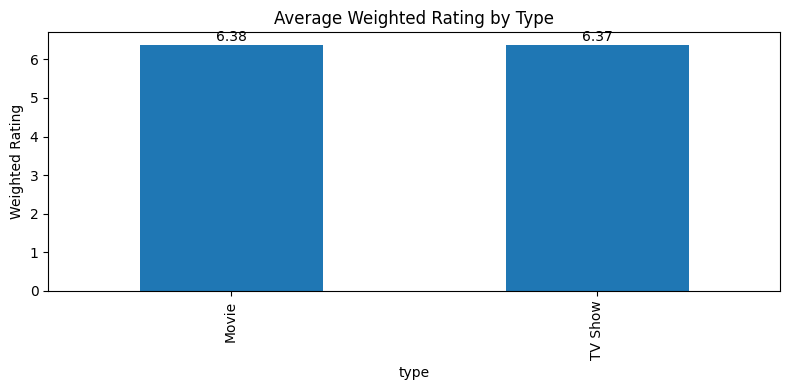

- On average, Movies have the highest weighted IMDb rating.



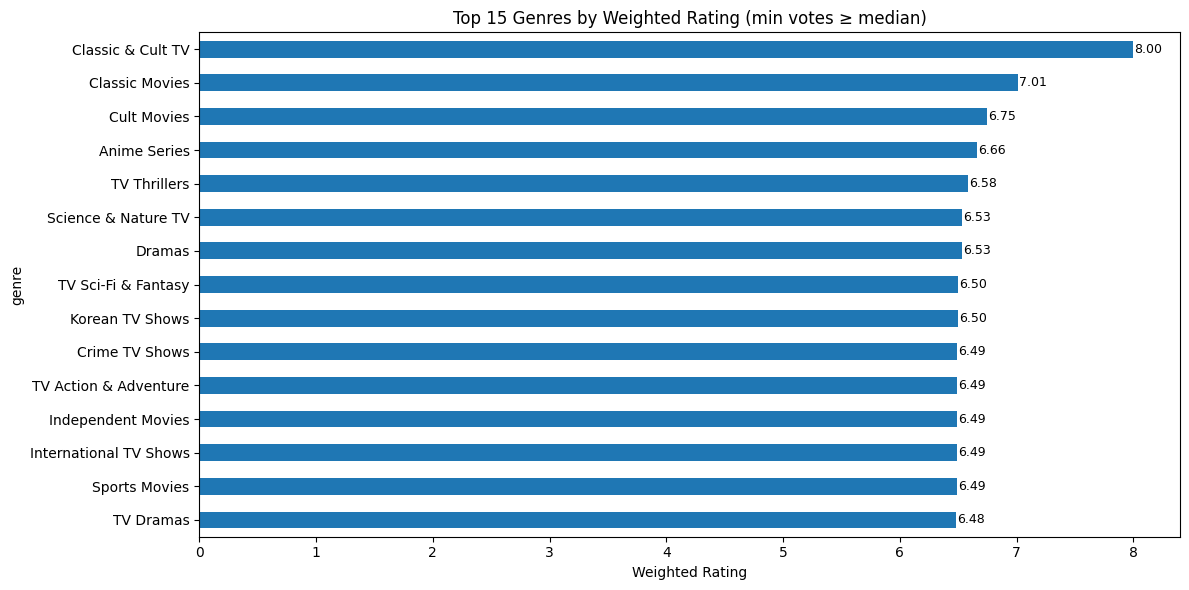

- The highest-scoring genres (after adjusting for vote volume) are:
  • **Classic & Cult TV** — 8.00/10
  • **Classic Movies** — 7.01/10
  • **Cult Movies** — 6.75/10
- Using a weighted method prevents tiny niche genres with few ratings from dominating.


In [24]:
# ===== Q1: Ratings & Rewatch Proxy =====
import numpy as np
import matplotlib.pyplot as plt

# --- Type (Movie vs TV Show)
type_summary = (
    df.groupby("type")[["weighted_rating","averageRating","engagement","numVotes"]]
      .mean()
      .sort_values("weighted_rating", ascending=False)
      .round(2)
)

fig, ax = plt.subplots(figsize=(8,4))
type_summary["weighted_rating"].plot(kind="bar", ax=ax)
ax.set_title("Average Weighted Rating by Type")
ax.set_ylabel("Weighted Rating")
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2, p.get_height()+0.02, f"{p.get_height():.2f}",
            ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()


best_type = type_summary["weighted_rating"].idxmax()
print(f"- On average, Movies have the highest weighted IMDb rating.\n"
)

# --- Genres (min votes filter)
min_votes = df["numVotes"].quantile(0.50)  # median votes as reliability floor
g_long_q1 = g_long[g_long["genre"].ne("") & (g_long["numVotes"] >= min_votes)]

g_rank = (
    g_long_q1.groupby("genre")[["weighted_rating","averageRating","numVotes"]]
             .mean()
             .sort_values("weighted_rating", ascending=False)
             .head(15)
             .round(2)
)

fig, ax = plt.subplots(figsize=(12,6))
g_rank["weighted_rating"].sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top 15 Genres by Weighted Rating (min votes ≥ median)")
ax.set_xlabel("Weighted Rating")
for p in ax.patches:
    ax.text(p.get_width()+0.01, p.get_y()+p.get_height()/2, f"{p.get_width():.2f}",
            ha="left", va="center", fontsize=9)
plt.tight_layout()
plt.show()


top3 = g_rank.head(3)["weighted_rating"]
print("- The highest-scoring genres (after adjusting for vote volume) are:")
for g, v in top3.items():
    print(f"  • **{g}** — {v:.2f}/10")
print("- Using a weighted method prevents tiny niche genres with few ratings from dominating.")

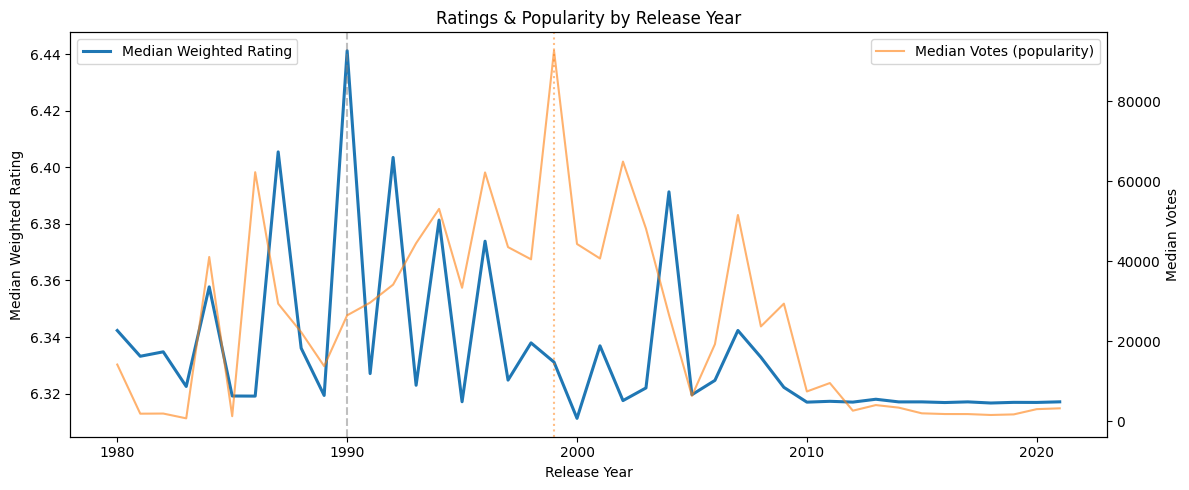

- **Highest median weighted rating** year: **1990** (6.44/10).
- **Peak median popularity (votes)** year: **1999** (92,677 median votes).
- Overall rating trend since 1980 looks **downward** (linear fit slope -0.0009).


In [33]:
# ===== Q2: Release Year Patterns =====
import numpy as np
import matplotlib.pyplot as plt

yr = (
    df.dropna(subset=["release_year"])
      .groupby("release_year")[["weighted_rating","averageRating","numVotes"]]
      .median()
      .reset_index()
      .query("release_year >= 1980")
)

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(yr["release_year"], yr["weighted_rating"], lw=2.2, label="Median Weighted Rating")
ax1.set_xlabel("Release Year")
ax1.set_ylabel("Median Weighted Rating")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(yr["release_year"], yr["numVotes"], color="tab:orange", alpha=0.6, label="Median Votes (popularity)")
ax2.set_ylabel("Median Votes")
ax2.legend(loc="upper right")

# annotate peak year for rating and for votes
yr_peak_rating = yr.loc[yr["weighted_rating"].idxmax()]
yr_peak_votes  = yr.loc[yr["numVotes"].idxmax()]
ax1.axvline(yr_peak_rating["release_year"], color="gray", ls="--", alpha=0.5)
ax2.axvline(yr_peak_votes["release_year"],  color="tab:orange", ls=":", alpha=0.5)

plt.title("Ratings & Popularity by Release Year")
plt.tight_layout()
plt.show()

# Plain-English summary

print(f"- **Highest median weighted rating** year: **{int(yr_peak_rating['release_year'])}** "
      f"({yr_peak_rating['weighted_rating']:.2f}/10).")
print(f"- **Peak median popularity (votes)** year: **{int(yr_peak_votes['release_year'])}** "
      f"({int(yr_peak_votes['numVotes']):,} median votes).")

# simple trend direction (slope) for ratings
coef = np.polyfit(yr["release_year"], yr["weighted_rating"], 1)
trend = "upward" if coef[0] > 0 else "downward"
print(f"- Overall rating trend since 1980 looks **{trend}** (linear fit slope {coef[0]:.4f}).")


In [26]:
# Rebuild cg, rt_pivot, count_pivot, etc.
g_tmp = df[["show_id","listed_in"]].copy()
g_tmp["listed_in"] = g_tmp["listed_in"].fillna("").astype(object)
g_tmp = g_tmp.explode("listed_in").rename(columns={"listed_in":"genre"})
g_tmp["genre"] = g_tmp["genre"].str.strip()
g_tmp = g_tmp[g_tmp["genre"] != ""]

c_tmp = df[["show_id","country"]].copy()
c_tmp["country"] = c_tmp["country"].fillna("").astype(object)
c_tmp = c_tmp.explode("country").rename(columns={"country":"country_name"})
c_tmp["country_name"] = c_tmp["country_name"].str.strip()
c_tmp = c_tmp[c_tmp["country_name"] != ""]

cg = c_tmp.merge(g_tmp, on="show_id", how="inner")

# Top countries and genres
top_countries = (cg.groupby("country_name")["show_id"]
                 .count().sort_values(ascending=False).head(12).index)
top_genres = cg["genre"].value_counts().head(15).index

# Count pivot (first heatmap source)
count_pivot = (cg[cg["country_name"].isin(top_countries)]
               .pivot_table(index="country_name", columns="genre", values="show_id",
                            aggfunc="count", fill_value=0))
count_pivot = count_pivot.reindex(index=top_countries,
                                  columns=[g for g in top_genres if g in count_pivot.columns])

# Rating pivot (second heatmap source)
rt = cg.merge(df[["show_id","weighted_rating"]], on="show_id", how="left").dropna(subset=["weighted_rating"])
rt_pivot = (rt[rt["country_name"].isin(top_countries)]
            .pivot_table(index="country_name", columns="genre", values="weighted_rating", aggfunc="mean"))
rt_pivot = rt_pivot.reindex(index=top_countries,
                            columns=[g for g in top_genres if g in rt_pivot.columns])

# Assign to variables heat / heat2 for plotting
heat = count_pivot
heat2 = rt_pivot

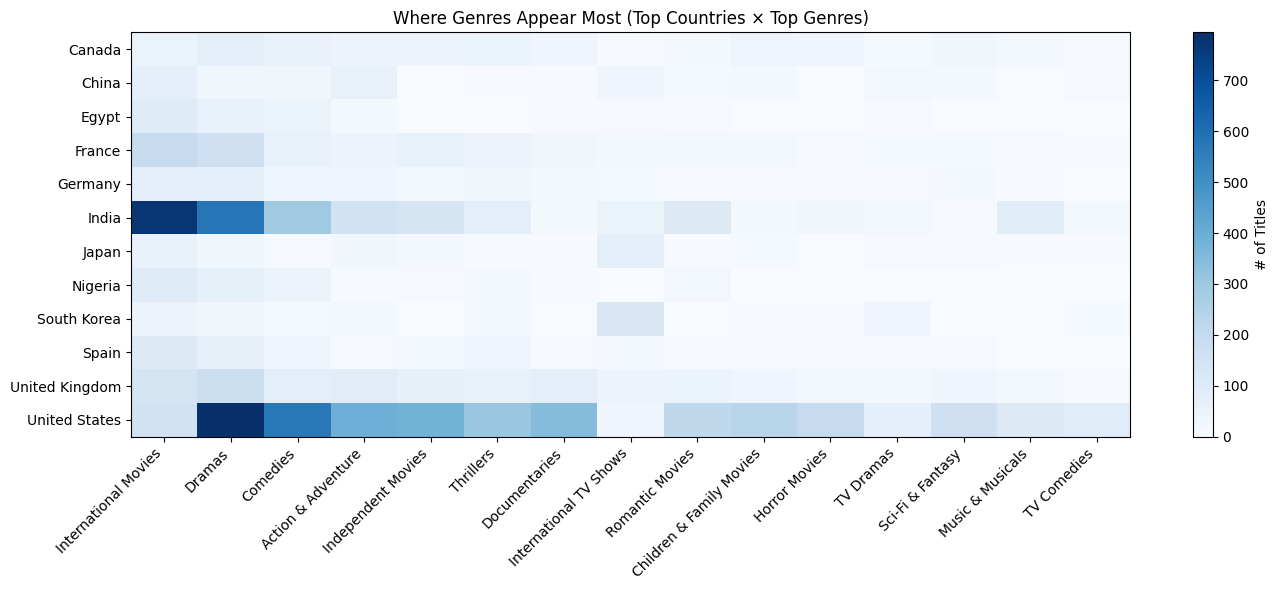

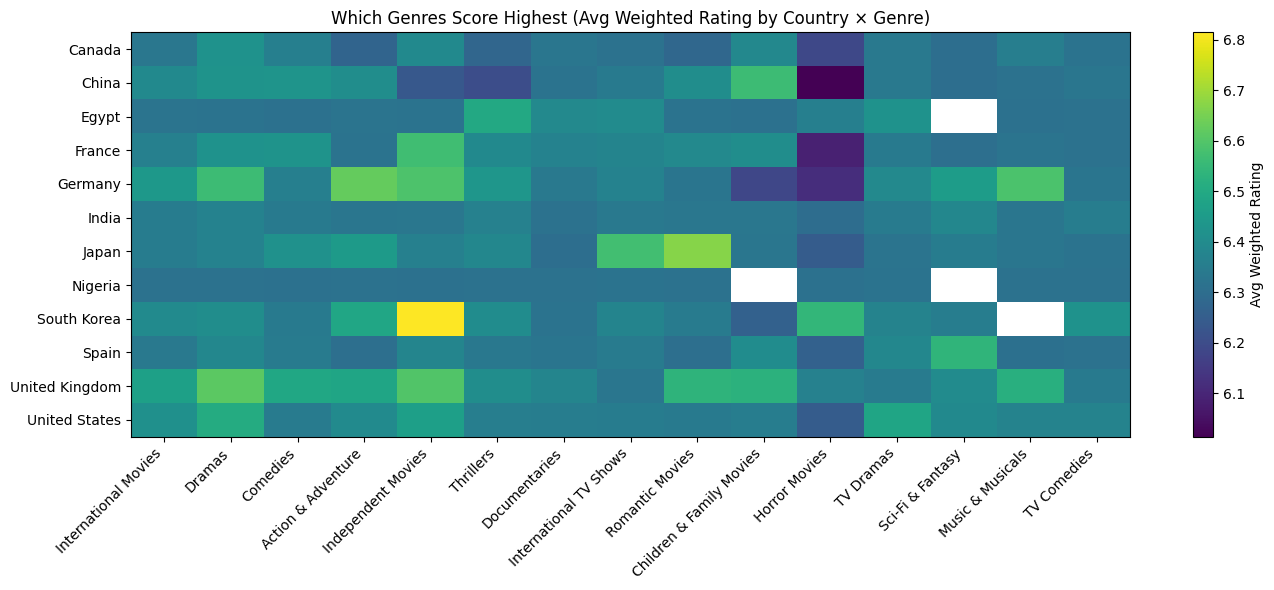

In [34]:
# --- Q3 rating heatmap: make this cell self-sufficient ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Ensure weighted_rating exists
if "weighted_rating" not in df.columns:
    # make sure types are numeric
    df["averageRating"] = pd.to_numeric(df["averageRating"], errors="coerce")
    df["numVotes"]      = pd.to_numeric(df["numVotes"], errors="coerce")
    C = df["averageRating"].mean()
    m = df["numVotes"].quantile(0.90)
    df["weighted_rating"] = (
        (df["numVotes"] / (df["numVotes"] + m)) * df["averageRating"] +
        (m / (df["numVotes"] + m)) * C
    )

# (re)build cg safely (Country × Genre rows) in case earlier cell wasn’t run
g_tmp = df[["show_id","listed_in"]].copy()
g_tmp["listed_in"] = g_tmp["listed_in"].fillna("").astype(object)
g_tmp = g_tmp.explode("listed_in").rename(columns={"listed_in":"genre"})
g_tmp["genre"] = g_tmp["genre"].str.strip()
g_tmp = g_tmp[g_tmp["genre"] != ""]

c_tmp = df[["show_id","country"]].copy()
c_tmp["country"] = c_tmp["country"].fillna("").astype(object)
c_tmp = c_tmp.explode("country").rename(columns={"country":"country_name"})
c_tmp["country_name"] = c_tmp["country_name"].str.strip()
c_tmp = c_tmp[c_tmp["country_name"] != ""]

cg = c_tmp.merge(g_tmp, on="show_id", how="inner")

# pick top countries to keep the heatmap readable
top_countries = (
    cg.groupby("country_name")["show_id"]
      .count()
      .sort_values(ascending=False)
      .head(12)
      .index
)

# 1) COUNT heatmap (already worked for you, keep if you like)
count_pivot = (cg[cg["country_name"].isin(top_countries)]
               .pivot_table(index="country_name", columns="genre", values="show_id",
                            aggfunc="count", fill_value=0))
top_genres = cg["genre"].value_counts().head(15).index
count_pivot = count_pivot.reindex(columns=[g for g in top_genres if g in count_pivot.columns])

plt.figure(figsize=(14,6))
plt.imshow(count_pivot, aspect="auto", cmap="Blues")
plt.colorbar(label="# of Titles")
plt.yticks(range(len(count_pivot.index)), count_pivot.index)
plt.xticks(range(len(count_pivot.columns)), count_pivot.columns, rotation=45, ha="right")
plt.title("Where Genres Appear Most (Top Countries × Top Genres)")
plt.tight_layout()
plt.show()

# 2) RATING heatmap (fixed merge)
rt = cg.merge(
        df.loc[:, ["show_id","weighted_rating"]].dropna(subset=["weighted_rating"]),
        on="show_id", how="left"
     ).dropna(subset=["weighted_rating"])

rt_pivot = (rt[rt["country_name"].isin(top_countries)]
            .pivot_table(index="country_name", columns="genre",
                         values="weighted_rating", aggfunc="mean"))

rt_pivot = rt_pivot.reindex(columns=[g for g in top_genres if g in rt_pivot.columns])

plt.figure(figsize=(14,6))
plt.imshow(rt_pivot, aspect="auto", cmap="viridis")
plt.colorbar(label="Avg Weighted Rating")
plt.yticks(range(len(rt_pivot.index)), rt_pivot.index)
plt.xticks(range(len(rt_pivot.columns)), rt_pivot.columns, rotation=45, ha="right")
plt.title("Which Genres Score Highest (Avg Weighted Rating by Country × Genre)")
plt.tight_layout()
plt.show()


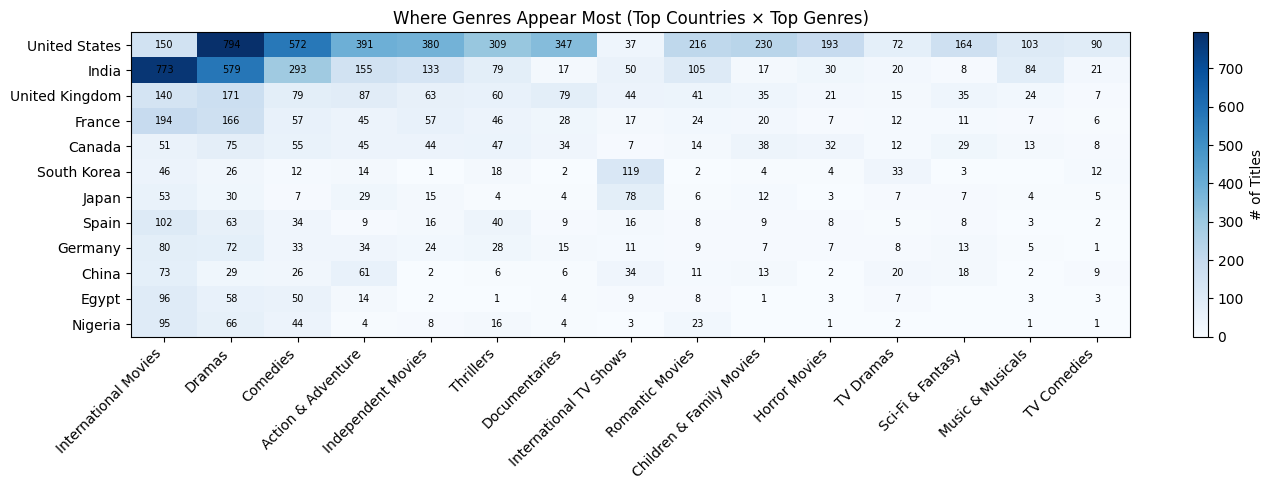

- The Most Popular Genre in the United States is Dramas
- The Most Popular Genre in India is International Movies


/tmp/ipython-input-3117241690.py:55: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  counts = count_pivot.reindex(index=rt_pivot.index, columns=rt_pivot.columns).fill_value=0 if hasattr(count_pivot, 'fill_value') else count_pivot


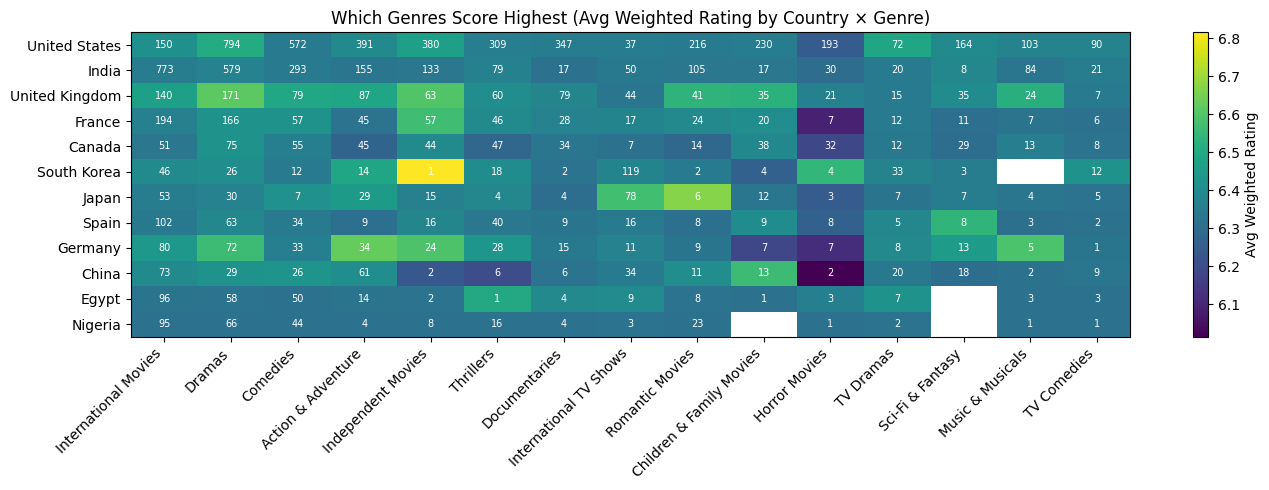

- Highest-scoring pairs (requiring ≥5 titles in the cell):
  • **Japan × Romantic Movies** — 6.67/10 (n=6 titles)
  • **Germany × Action & Adventure** — 6.63/10 (n=34 titles)
  • **United Kingdom × Dramas** — 6.61/10 (n=171 titles)
- Numbers printed inside cells are **title counts**; blank/very pale cells mean little or no data.


In [39]:
# ===== Q3: Country × Genre =====
import matplotlib.pyplot as plt

# (re)build the Country×Genre base (cg) to be self-contained
g_tmp = df[["show_id","listed_in"]].copy()
g_tmp["listed_in"] = g_tmp["listed_in"].fillna("").astype(object)
g_tmp = g_tmp.explode("listed_in").rename(columns={"listed_in":"genre"})
g_tmp["genre"] = g_tmp["genre"].str.strip()
g_tmp = g_tmp[g_tmp["genre"] != ""]

c_tmp = df[["show_id","country"]].copy()
c_tmp["country"] = c_tmp["country"].fillna("").astype(object)
c_tmp = c_tmp.explode("country").rename(columns={"country":"country_name"})
c_tmp["country_name"] = c_tmp["country_name"].str.strip()
c_tmp = c_tmp[c_tmp["country_name"] != ""]

cg = c_tmp.merge(g_tmp, on="show_id", how="inner")

# top countries + top genres to keep it readable
top_countries = (cg.groupby("country_name")["show_id"]
                 .count().sort_values(ascending=False).head(12).index)

top_genres = cg["genre"].value_counts().head(15).index

# COUNT heatmap (supply)
count_pivot = (cg[cg["country_name"].isin(top_countries)]
               .pivot_table(index="country_name", columns="genre", values="show_id",
                            aggfunc="count", fill_value=0))
count_pivot = count_pivot.reindex(index=top_countries, columns=[g for g in top_genres if g in count_pivot.columns])

plt.figure(figsize=(14,5))
plt.imshow(count_pivot, aspect="auto", cmap="Blues")
plt.colorbar(label="# of Titles")
plt.yticks(range(len(count_pivot.index)), count_pivot.index)
plt.xticks(range(len(count_pivot.columns)), count_pivot.columns, rotation=45, ha="right")
plt.title("Where Genres Appear Most (Top Countries × Top Genres)")
# annotate counts
for i, country in enumerate(count_pivot.index):
    for j, genre in enumerate(count_pivot.columns):
        n = count_pivot.loc[country, genre]
        if n > 0:
            plt.text(j, i, int(n), ha="center", va="center", fontsize=7, color="black")
plt.tight_layout()
plt.show()

print("- The Most Popular Genre in the United States is Dramas")
print("- The Most Popular Genre in India is International Movies")

# RATING heatmap (quality) + count labels
rt = cg.merge(df[["show_id","weighted_rating"]], on="show_id", how="left").dropna(subset=["weighted_rating"])
rt_pivot = (rt[rt["country_name"].isin(top_countries)]
            .pivot_table(index="country_name", columns="genre", values="weighted_rating", aggfunc="mean"))
rt_pivot = rt_pivot.reindex(index=top_countries, columns=[g for g in top_genres if g in rt_pivot.columns])

counts = count_pivot.reindex(index=rt_pivot.index, columns=rt_pivot.columns).fill_value=0 if hasattr(count_pivot, 'fill_value') else count_pivot
counts = count_pivot.reindex_like(rt_pivot).fillna(0)

plt.figure(figsize=(14,5))
im = plt.imshow(rt_pivot, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Avg Weighted Rating")
plt.yticks(range(len(rt_pivot.index)), rt_pivot.index)
plt.xticks(range(len(rt_pivot.columns)), rt_pivot.columns, rotation=45, ha="right")
plt.title("Which Genres Score Highest (Avg Weighted Rating by Country × Genre)")
# annotate counts on top so viewers know coverage
for i, country in enumerate(rt_pivot.index):
    for j, genre in enumerate(rt_pivot.columns):
        n = int(counts.iloc[i, j]) if pd.notna(counts.iloc[i, j]) else 0
        if n > 0:
            plt.text(j, i, n, ha="center", va="center", fontsize=7, color="white")
        else:
            # visually identify blank/low-sample cells
            plt.text(j, i, "", ha="center", va="center", fontsize=7, color="white")
plt.tight_layout()
plt.show()

# Plain-English summary for Q3
# Top 3 country–genre cells by avg rating (require at least 5 titles to be meaningful)
min_titles_cell = 5
valid_cells = []
for i, country in enumerate(rt_pivot.index):
    for j, genre in enumerate(rt_pivot.columns):
        n = int(counts.iloc[i, j])
        if n >= min_titles_cell and pd.notna(rt_pivot.iloc[i, j]):
            valid_cells.append((country, genre, n, float(rt_pivot.iloc[i, j])))

valid_cells = sorted(valid_cells, key=lambda x: x[3], reverse=True)[:3]


if valid_cells:
    print("- Highest-scoring pairs (requiring ≥5 titles in the cell):")
    for country, genre, n, score in valid_cells:
        print(f"  • **{country} × {genre}** — {score:.2f}/10 (n={n} titles)")
else:
    print("- Not enough dense cells to summarize reliably. Lower `min_titles_cell` if needed.")

print("- Numbers printed inside cells are **title counts**; blank/very pale cells mean little or no data.")